## Radial Groundwater Flow Model

This example, ex-gwf-radial, shows how the MODFLOW 6 DISU Package
can be used to simulate an axisymmetric radial model.

The example corresponds to the first example described in:
   Bedekar, V., Scantlebury, L., and Panday, S. (2019).
      Axisymmetric Modeling Using MODFLOW-USG.Groundwater, 57(5), 772-777.

And the numerical result is compared against the analytical solution
presented in Equation 17 of
   Neuman, S. P. (1974). Effect of partial penetration on flow in
   unconfined aquifers considering delayed gravity response.
   Water resources research, 10(2), 303-312

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl
from math import sqrt

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from matplotlib.patches import Circle
from modflow_devtools.misc import get_env, timed

# Solve definite integral using Fortran library QUADPACK
from scipy.integrate import quad

# Find a root of a function using Brent's method within a bracketed range
from scipy.optimize import brentq

# Zero Order Bessel Function
from scipy.special import j0, jn_zeros

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-rad-disu"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

Define some utilities for creating the grid and solving the radial solution

In [2]:
# Radial unconfined drawdown solution from Neuman 1974
pi = 3.141592653589793
sin = np.sin
cos = np.cos
sinh = np.sinh
cosh = np.cosh
exp = np.exp


def get_disu_radial_kwargs(
    nlay,
    nradial,
    radius_outer,
    surface_elevation,
    layer_thickness,
    get_vertex=False,
):
    """
    Simple utility for creating radial unstructured elements
    with the disu package.

    Input assumes that each layer contains the same radial band,
    but their thickness can be different.

    Parameters
    ----------
    nlay: number of layers (int)
    nradial: number of radial bands to construct (int)
    radius_outer: Outer radius of each radial band (array-like float with nradial length)
    surface_elevation: Top elevation of layer 1 as either a float or nradial array-like float values.
                       If given as float, then value is replicated for each radial band.
    layer_thickness: Thickness of each layer as either a float or nlay array-like float values.
                     If given as float, then value is replicated for each layer.
    """
    pi = 3.141592653589793

    def get_nn(lay, rad):
        return nradial * lay + rad

    def get_rad_array(var, rep):
        try:
            dim = len(var)
        except:
            dim, var = 1, [var]

        if dim != 1 and dim != rep:
            raise IndexError(
                f"get_rad_array(var): var must be a scalar or have len(var)=={rep}"
            )

        if dim == 1:
            return np.full(rep, var[0], dtype=np.float64)
        else:
            return np.array(var, dtype=np.float64)

    nodes = nlay * nradial
    surf = get_rad_array(surface_elevation, nradial)
    thick = get_rad_array(layer_thickness, nlay)

    iac = np.zeros(nodes, dtype=int)
    ja = []
    ihc = []
    cl12 = []
    hwva = []

    area = np.zeros(nodes, dtype=float)
    top = np.zeros(nodes, dtype=float)
    bot = np.zeros(nodes, dtype=float)

    for lay in range(nlay):
        st = nradial * lay
        sp = nradial * (lay + 1)
        top[st:sp] = surf - thick[:lay].sum()
        bot[st:sp] = surf - thick[: lay + 1].sum()

    for lay in range(nlay):
        for rad in range(nradial):
            # diagonal/self
            n = get_nn(lay, rad)
            ja.append(n)
            iac[n] += 1
            if rad > 0:
                area[n] = pi * (radius_outer[rad] ** 2 - radius_outer[rad - 1] ** 2)
            else:
                area[n] = pi * radius_outer[rad] ** 2
            ihc.append(n + 1)
            cl12.append(n + 1)
            hwva.append(n + 1)
            # up
            if lay > 0:
                ja.append(n - nradial)
                iac[n] += 1
                ihc.append(0)
                cl12.append(0.5 * (top[n] - bot[n]))
                hwva.append(area[n])
            # to center
            if rad > 0:
                ja.append(n - 1)
                iac[n] += 1
                ihc.append(1)
                cl12.append(0.5 * (radius_outer[rad] - radius_outer[rad - 1]))
                hwva.append(2.0 * pi * radius_outer[rad - 1])

            # to outer
            if rad < nradial - 1:
                ja.append(n + 1)
                iac[n] += 1
                ihc.append(1)
                hwva.append(2.0 * pi * radius_outer[rad])
                if rad > 0:
                    cl12.append(0.5 * (radius_outer[rad] - radius_outer[rad - 1]))
                else:
                    cl12.append(radius_outer[rad])
            # bottom
            if lay < nlay - 1:
                ja.append(n + nradial)
                iac[n] += 1
                ihc.append(0)
                cl12.append(0.5 * (top[n] - bot[n]))
                hwva.append(area[n])

    # Build rectangular equivalent of radial coordinates (unwrap radial bands)
    if get_vertex:
        perimeter_outer = np.fromiter(
            (2.0 * pi * rad for rad in radius_outer),
            dtype=float,
            count=nradial,
        )
        xc = 0.5 * radius_outer[0]
        yc = 0.5 * perimeter_outer[-1]
        # all cells have same y-axis cell center; yc is costant
        #
        # cell2d: [icell2d, xc, yc, ncvert, icvert]; first node: cell2d = [[0, xc, yc, [2, 1, 0]]]
        cell2d = []
        for lay in range(nlay):
            n = get_nn(lay, 0)
            cell2d.append([n, xc, yc, 3, 2, 1, 0])
        #
        xv = radius_outer[0]
        # half perimeter is equal to the y shift for vertices
        sh = 0.5 * perimeter_outer[0]
        vertices = [
            [0, 0.0, yc],
            [1, xv, yc - sh],
            [2, xv, yc + sh],
        ]  # vertices: [iv, xv, yv]
        iv = 3
        for r in range(1, nradial):
            # radius_outer[r-1] + 0.5*(radius_outer[r] - radius_outer[r-1])
            xc = 0.5 * (radius_outer[r - 1] + radius_outer[r])
            for lay in range(nlay):
                n = get_nn(lay, r)
                # cell2d: [icell2d, xc, yc, ncvert, icvert]
                cell2d.append([n, xc, yc, 4, iv - 2, iv - 1, iv + 1, iv])

            xv = radius_outer[r]
            # half perimeter is equal to the y shift for vertices
            sh = 0.5 * perimeter_outer[r]
            vertices.append([iv, xv, yc - sh])  # vertices: [iv, xv, yv]
            iv += 1
            vertices.append([iv, xv, yc + sh])  # vertices: [iv, xv, yv]
            iv += 1
        cell2d.sort(key=lambda row: row[0])  # sort by node number

    ja = np.array(ja, dtype=np.int32)
    nja = ja.shape[0]
    hwva = np.array(hwva, dtype=np.float64)
    kw = {}
    kw["nodes"] = nodes
    kw["nja"] = nja
    kw["nvert"] = None
    kw["top"] = top
    kw["bot"] = bot
    kw["area"] = area
    kw["iac"] = iac
    kw["ja"] = ja
    kw["ihc"] = ihc
    kw["cl12"] = cl12
    kw["hwva"] = hwva

    if get_vertex:
        kw["nvert"] = len(vertices)  # = 2*nradial + 1
        kw["vertices"] = vertices
        kw["cell2d"] = cell2d
        kw["angldegx"] = np.zeros(nja, dtype=float)
    else:
        kw["nvert"] = 0

    return kw


def _find_hyperbolic_max_value():
    seterr = np.seterr()
    np.seterr(all="ignore")
    inf = np.inf
    x = 10.0
    delt = 1.0
    for i in range(1000000):
        x += delt
        try:
            if inf == sinh(x):
                break
        except:
            break
    np.seterr(**seterr)
    return x - delt


_hyperbolic_max_value = _find_hyperbolic_max_value()


def _find_hyperbolic_equivalent_value():
    x = 10.0
    delt = 0.0001
    for i in range(1000000):
        x += delt
        if x > _hyperbolic_max_value:
            break
        try:
            if sinh(x) == cosh(x):
                return x
        except:
            break
    return x - delt


_hyperbolic_equivalence = _find_hyperbolic_equivalent_value()


class RadialUnconfinedDrawdown:
    """
    Solves the drawdown that occurs from pumping from partial penetration
    in an unconfined, radial aquifer. Uses the method described in:
    Neuman, S. P. (1974). Effect of partial penetration on flow in
    unconfined aquifers considering delayed gravity response.
    Water resources research, 10(2), 303-312.
    """

    hyperbolic_max_value = _hyperbolic_max_value
    hyperbolic_equivalence = _hyperbolic_equivalence

    bottom: float
    Kr: float
    Kz: float
    Ss: float
    Sy: float
    well_top: float
    well_bot: float
    saturated_thickness: float

    _sigma: float
    _beta: float

    def __init__(
        self,
        bottom_elevation,
        hydraulic_conductivity_radial=None,
        hydraulic_conductivity_vertical=None,
        specific_storage=None,
        specific_yield=None,
        well_screen_elevation_top=None,
        well_screen_elevation_bottom=None,
        water_table_elevation=None,
        saturated_thickness=None,
    ):
        """
        Initialize unconfined, radial groundwater model to solve drawdown
        at an observation location in response to pumping at the center of
        the model (that is, the well extracts water at radius = 0).

        Parameters
        ----------
        rad : int
            radial band number (0 to nradial-1)

        bottom_elevation : float
            Elevation of the impermeable base of the model ($L$)
        hydraulic_conductivity_radial : float
            Radial direction hydraulic conductivity of model ($L/T$)
        hydraulic_conductivity_vertical : float
            Vertical (z) direction hydraulic conductivity of model ($L/T$)
        specific_storage : float
            Specific storage of aquifer ($1/T$)
        specific_yield : float
            Specific yield of aquifer ($-$)
        well_screen_elevation_top : float
            Pumping well's top screen elevation ($L$)
        well_screen_elevation_bottom : float
            Pumping well's bottom screen elevation ($L$)
        water_table_elevation : float
            Initial water table elevation. Note, saturated_thickness (b) is
            calculated as $water_table_elevation - bottom_elevation$ ($L$)
        saturated_thickness : float
            Specify the initial saturated thickness of the unconfined aquifer.
            Value is used to calculate the water_table_elevation. If
            water_table_elevation is defined, then saturated_thickness input
            is ignored and set to
            $water_table_elevation - bottom_elevation$ ($L$)
        """

        self.bottom = float(bottom_elevation)
        self.Kr = self._float_or_none(hydraulic_conductivity_radial)
        self.Kz = self._float_or_none(hydraulic_conductivity_vertical)
        self.Ss = self._float_or_none(specific_storage)
        self.Sy = self._float_or_none(specific_yield)
        self.well_top = self._float_or_none(well_screen_elevation_top)
        self.well_bot = self._float_or_none(well_screen_elevation_bottom)

        if water_table_elevation is not None and saturated_thickness is not None:
            raise RuntimeError(
                "RadialUnconfinedDrawdown() must specify only "
                + "water_table_elevation or saturated_thickness, but not "
                + "both at the same time."
            )

        if water_table_elevation is not None:
            self.saturated_thickness = float(water_table_elevation) - self.bottom
        elif saturated_thickness is not None:
            self.saturated_thickness = float(saturated_thickness)
        else:
            self.saturated_thickness = None

    def _prop_check(self):
        error = []
        if self.Kr is None:
            error.append("hydraulic_conductivity_radial")
        if self.Kz is None:
            error.append("hydraulic_conductivity_vertical")
        if self.Ss is None:
            error.append("specific_storage")
        if self.Sy is None:
            error.append("specific_yield")
        if self.well_top is None:
            error.append("well_screen_elevation_top")
        if self.well_bot is None:
            error.append("well_screen_elevation_bottom")
        if error:
            raise RuntimeError(
                "RadialUnconfinedDrawdown: Attempted to solve radial "
                + "groundwater model\nwith the following input not specified\n"
                + "\n".join(error)
            )
        if self.well_top <= self.well_bot:
            raise RuntimeError(
                "RadialUnconfinedDrawdown: "
                + "well_screen_elevation_top <= well_screen_elevation_bottom\n"
                + f"That is: {self.well_top} <= "
                + f"{self.well_bot}"
            )

    def drawdown(
        self,
        pump,
        time,
        radius,
        observation_elevation,
        observation_elevation_bot=None,
        sumrtol=1.0e-6,
        u_n_rtol=1.0e-5,
        epsabs=1.49e-8,
        bessel_loop_limit=5,
        quad_limit=128,
        show_progress=False,
        ty_time=False,
        ts_time=False,
        as_head=False,
    ):
        """
        Solves the radial model's drawdown for a given pumping rate and
        time at a given observation point
        (radius, observation_elevation) or observation well screen interval
        (radius, observation_elevation:observation_elevation_bot).
        This solves drawdown by integrating equation 17 from
        Neuman, S. P. (1974). Effect of partial penetration on flow in
        unconfined aquifers considering delayed gravity response.
        Water resources research, 10(2), 303-312

        Parameters
        ----------
        pump : float
            Pumping rate of well at center of radial model ($L^3/T$)
            Positive values are the water extraction rate.
            Negative or zero values indicate no pumping and result returns
            the dimensionless drawdown instead of regular drawdown.
        time : float or Sequence[float]
            Time that observation is made
        radius : float
            Radius of the observation location (distance from well, $L$)
        observation_elevation : float
            Either the location of the observation point, or the top elevation
            of the observation well screen ($L$)
        observation_elevation_bot : float
            If specified, then represents the bottom elevation of the
            observation well screen. If not specified (or set to None), then
            observation location is treated as a single point, located at
            radius and observation_elevation ($L$)
        sumrtol : float
            Solution involves integration of $y$ variable from 0 to ∞ from
            Equation 17 in:
            Neuman, S. P. (1974). Effect of partial penetration on flow in
            unconfined aquifers considering delayed gravity response.
            Water resources research, 10(2), 303-312.

            The integration is broken into subsections that are spaced around
            bessel function roots. The integration is complete when a
            three sequential subsection solutions are less than
            sumrtol times the largest subsection.
            That is, the last included subsection contributes a
            relatively small value compared to the largest of the sum.
        u_n_rtol : float
            Terminates the solution of the infinite series:
            $\\sum_{n=1}^{\\infty} u_n(y)$
            when
            $u_n(y) < u_n(0) * u_n_rtol$
        epsabs : float or int
            scipy.integrate.quad absolute error tolerance.
            Passed directly to that function's `epsabs` kwarg.
        bessel_loop_limit : int
            the integral is solved along each bessel function root.
            The first 1024 roots are precalculated and automatically increased
            if more are required. The upper limit for calculated roots is
            1024 * 2 ^ bessel_loop_limit
            If this limit is reached, then a warning is raised.
        quad_limit : int
            scipy.integrate.quad upper bound on the number of
            subintervals used in the adaptive algorithm.
            Passed directly to that function's `limit` kwarg.
        show_progress : bool
           if True, then progress is printed to the command prompt in the form:
        ty_time : bool
           if True, then `time` kwarg is dimensionless time with
           respect to Specific Yield
        ts_time : bool
           if True, then `time` kwarg is dimensionless time with
           respect to Specific Storage.
        as_head : bool
            If true, then drawdown result is converted to
            head using the model bottom and initial saturated thickness.
            If pump > 0, then as_head is ignored.

        Returns
        -------
        result : float or list[float]
            If time is float, then result is float.
            If time is Sequence[float], then result is list[float].

            If pump > 0, then result is the drawdown that occurs
            from pump at time and radius at observation point
            observation_elevation or from the observation well
            screen interval observation_elevation to
            observation_elevation_top ($L$).


            If pump <= 0, then result is converted to
            dimensionless drawdown ($-$)
        """
        if not hasattr(time, "strip") and hasattr(time, "__iter__"):
            return self.drawdown_times(
                pump,
                time,
                radius,
                observation_elevation,
                observation_elevation_bot,
                sumrtol,
                u_n_rtol,
                epsabs,
                bessel_loop_limit,
                quad_limit,
                show_progress,
                ty_time,
                ts_time,
                as_head,
            )

        return self.drawdown_times(
            pump,
            [time],
            radius,
            observation_elevation,
            observation_elevation_bot,
            sumrtol,
            u_n_rtol,
            epsabs,
            bessel_loop_limit,
            quad_limit,
            show_progress,
            ty_time,
            ts_time,
            as_head,
        )[0]

    def drawdown_times(
        self,
        pump,
        times,
        radius,
        observation_elevation,
        observation_elevation_bot=None,
        sumrtol=1.0e-6,
        u_n_rtol=1.0e-5,
        epsabs=1.49e-8,
        bessel_loop_limit=5,
        quad_limit=128,
        show_progress=False,
        ty_time=False,
        ts_time=False,
        as_head=False,
    ):
        # Same as self.drawdown, but times is a list[float] of
        # observation times and returns a list[float] drawdowns.

        if bessel_loop_limit < 1:
            bessel_loop_limit = 1

        bessel_roots0 = 1024
        bessel_roots = bessel_roots0
        bessel_root_limit_reached = []

        self._prop_check()
        if ty_time and ts_time:
            raise RuntimeError(
                "RadialUnconfinedDrawdown.drawdown_times "
                + "cannot set both ty_time and ts_time to True."
            )

        r = radius
        b = self.saturated_thickness

        sigma = self.Ss * b / self.Sy
        beta = (r / b) * (r / b) * (self.Kz / self.Kr)
        sqrt_beta = sqrt(beta)

        if np.isnan(pump) or pump <= 0.0:
            # Return dimensionless drawdown
            coef = 1.0
        else:
            coef = pump / (4.0 * pi * b * self.Kr)

        # dimensionless well screen top
        dd = (self.saturated_thickness + self.bottom - self.well_top) / b
        # dimensionless well screen bottom
        ld = (self.saturated_thickness + self.bottom - self.well_bot) / b

        # Solution must be in dimensionless time with respect to Ss;
        # ts = kr*b*t/(Ss*b*r^2)
        if ty_time:
            ts_list = self.ty2ts(times)
        elif ts_time:
            ts_list = times
        else:
            ts_list = self.time2ts(times, r)

        # distance above bottom to observation point or obs screen bottom
        zt = observation_elevation - self.bottom
        if observation_elevation_bot is None:
            # Single Point Observation
            zd = zt / b  # dimensionless elevation of observation point
            neuman1974_integral = self.neuman1974_integral1
            obs_arg = (zd,)
        else:
            # distance above bottom to observation screen top
            zb = observation_elevation_bot - self.bottom
            # dimensionless elevation of observation screen interval
            ztd, zbd = zt / b, zb / b
            # dz = 1 / (zt - zb)  -> implied in the
            #                        modified u0 and uN functions
            neuman1974_integral = self.neuman1974_integral2
            obs_arg = (zbd, ztd)

        s = []  # drawdown, one to one match with times
        nstp = len(ts_list)
        for stp, ts in enumerate(ts_list):
            if show_progress:
                print(
                    f"Solving {stp+1:4d} of {nstp}; " + f"time = {self.ts2time(ts, r)}",
                    end="",
                )

            args = (sigma, beta, sqrt_beta, ld, dd, ts, *obs_arg, u_n_rtol)
            sol = 0.0
            y0, y1 = 0.0, 0.0
            mxdelt = 0.0

            j0_roots = jn_zeros(0, bessel_roots) / sqrt_beta
            jr0 = 0
            jr1 = j0_roots.size

            converged = 0
            bessel_loop_count = 0
            while converged < 3 and bessel_loop_count <= bessel_loop_limit:
                if bessel_loop_count > 0:
                    bessel_roots *= 2
                    j0_roots = jn_zeros(0, bessel_roots) / sqrt_beta
                    jr0, jr1 = jr1, j0_roots.size

                j0_roots_iter = np.nditer(j0_roots[jr0:jr1])
                bessel_loop_count += 1
                # Iterate over two roots to get full cycle
                for j0_root in j0_roots_iter:
                    # First root
                    y0, y1 = y1, j0_root
                    delt1 = quad(
                        neuman1974_integral,
                        y0,
                        y1,
                        args,
                        epsabs=epsabs,
                        limit=quad_limit,
                    )[0]
                    #
                    # Second root
                    y0, y1 = y1, next(j0_roots_iter)
                    delt2 = quad(
                        neuman1974_integral,
                        y0,
                        y1,
                        args,
                        epsabs=epsabs,
                        limit=quad_limit,
                    )[0]

                    if np.isnan(delt1) or np.isnan(delt2):
                        break

                    sol += delt1 + delt2

                    adelt = abs(delt1 + delt2)
                    if adelt > mxdelt:
                        mxdelt = adelt
                    elif adelt < mxdelt * sumrtol:
                        converged += 1  # increment the convergence counter
                        # Converged if three sequential solutions (adelt)
                        # are less than mxdelt*sumrtol
                        if converged >= 3:
                            break
                    else:
                        converged = 0  # reset convergence counter
            if sol < 0.0:
                s.append(0.0)
            else:
                s.append(coef * sol)

            if converged < 3:
                bessel_root_limit_reached.append(stp)

            if show_progress:
                if converged < 3:
                    print(f"\ts = {s[-1]}\tbessel_loop_limit reached")
                else:
                    print(f"\ts = {s[-1]}")

        if pump > 0.0 and as_head:
            initial_head = self.bottom + self.saturated_thickness
            return [initial_head - drawdown for drawdown in s]

        if len(bessel_root_limit_reached) > 0:
            import warnings

            root = j0_roots[-1]
            bad_times = "\n".join([str(times[it]) for it in bessel_root_limit_reached])
            warnings.warn(
                "\n\nRadialUnconfinedDrawdown.drawdown_times failed to "
                + f"meet convergence sumrtol = {sumrtol}"
                + "\nwithin the precalculated Bessel root solutions "
                + "(convergence is evaluated at every second Bessel root).\n\n"
                + "The number of Bessel roots are automatically increased "
                + "up to:\n"
                + f"   {bessel_roots0} * 2^bessel_loop_limit\nwhere:\n"
                + "   bessel_loop_limit = {bessel_loop_limit}\n"
                + f"resulting in {1024*2**bessel_loop_limit} roots evaluated, "
                + "with the last root being {root}\n"
                + f"(That is, the Neuman integral was solved form 0 to {root})"
                + "\n\n"
                + "You can either ignore this warning\n"
                + "or to remove it attempt to increase bessel_loop_limit\n"
                + "or increase sumrtol (reducing accuracy).\n\nThe following "
                + "times are what triggered this warning:\n"
                + bad_times
                + "\n"
            )
        return s

    @staticmethod
    def neuman1974_integral1(y, alpha, beta, sqrt_beta, ld, dd, ts, zd, uN_tol=1.0e-6):
        """
        Solves equation 17 from
        Neuman, S. P. (1974). Effect of partial penetration on flow in
        unconfined aquifers considering delayed gravity response.
        Water resources research, 10(2), 303-312.
        """
        if y == 0.0 or ts == 0.0:
            return 0.0

        u0 = RadialUnconfinedDrawdown.u_0(alpha, beta, zd, ld, dd, ts, y)

        if np.isnan(u0):
            u0 = 0.0

        uN_func = RadialUnconfinedDrawdown.u_n
        mxdelt = 0.0
        uN = 0.0
        for n in range(1, 25001):
            delt = uN_func(alpha, beta, zd, ld, dd, ts, y, n)
            if np.isnan(delt):
                break
            uN += delt
            adelt = abs(delt)
            if adelt > mxdelt:
                mxdelt = adelt
            elif adelt < mxdelt * uN_tol:
                break

        return 4.0 * y * j0(y * sqrt_beta) * (u0 + uN)

    @staticmethod
    def gamma0(g, y, s):
        """
        Gamma0 root function from equation 18 in:
        Neuman, S. P. (1974). Effect of partial penetration on flow in
        unconfined aquifers considering delayed gravity response.
        Water resources research, 10(2), 303-312.
            => Solution must be constrained by g^2 < y^2

        To honor the constraint solution returns the absolute value
         of the solution.
        """
        if g >= _hyperbolic_equivalence:
            # sinh ≈ cosh for large g
            return s * g - (y * y - g * g)

        return s * g * sinh(g) - (y * y - g * g) * cosh(g)

    @staticmethod
    def gammaN(g, y, s):
        """
        GammaN root function from equation 19 in:
        Neuman, S. P. (1974). Effect of partial penetration on flow in
        unconfined aquifers considering delayed gravity response.
        Water resources research, 10(2), 303-312.
            => Solution must be constrained by (2n-1)(π/2)< g < nπ
        """
        return s * g * sin(g) + (y * y + g * g) * cos(g)

    @staticmethod
    def u_0(alpha, beta, z, l, d, ts, y):
        gamma0 = RadialUnconfinedDrawdown.gamma0

        a, b = 0.9 * y, y
        try:
            a, b = RadialUnconfinedDrawdown._get_bracket(gamma0, a, b, (y, alpha))
        except RuntimeError:
            a, b = RadialUnconfinedDrawdown._get_bracket(
                gamma0, 0.0, b, (y, alpha), 1000
            )

        g = brentq(gamma0, a, b, args=(y, alpha), maxiter=500, xtol=1.0e-16)

        # Check for cosh/sinh overflow
        if g > _hyperbolic_max_value:
            return 0.0

        y2 = y * y
        g2 = g * g
        num1 = 1 - exp(-ts * beta * (y2 - g2))
        num2 = cosh(g * z)
        num3 = sinh(g * (1 - d)) - sinh(g * (1 - l))
        den1 = y2 + (1 + alpha) * g2 - ((y2 - g2) ** 2) / alpha
        den2 = cosh(g)
        den3 = (l - d) * sinh(g)
        # num1*num2*num3 / (den1*den2*den3)
        return (num1 / den1) * (num2 / den2) * (num3 / den3)

    @staticmethod
    def u_n(alpha, beta, z, l, d, ts, y, n):
        gammaN = RadialUnconfinedDrawdown.gammaN

        a, b = (2 * n - 1) * (pi / 2.0), n * pi
        try:
            a, b = RadialUnconfinedDrawdown._get_bracket(gammaN, a, b, (y, alpha))
        except RuntimeError:
            a, b = RadialUnconfinedDrawdown._get_bracket(gammaN, a, b, (y, alpha), 1000)

        g = brentq(gammaN, a, b, args=(y, alpha), maxiter=500, xtol=1.0e-16)

        y2 = y * y
        g2 = g * g
        num1 = 1 - exp(-ts * beta * (y2 + g2))
        num2 = cos(g * z)
        num3 = sin(g * (1 - d)) - sin(g * (1 - l))
        den1 = y2 - (1 + alpha) * g2 - ((y2 + g2) ** 2) / alpha
        den2 = cos(g)
        den3 = (l - d) * sin(g)
        return num1 * num2 * num3 / (den1 * den2 * den3)

    @staticmethod
    def neuman1974_integral2(
        y, alpha, beta, sqrt_beta, ld, dd, ts, z1, z2, uN_tol=1.0e-10
    ):
        """
        Solves equation 20 from
        Neuman, S. P. (1974). Effect of partial penetration on flow in
        unconfined aquifers considering delayed gravity response.
        Water resources research, 10(2), 303-312.
        """
        if y == 0.0 or ts == 0.0:
            return 0.0

        u0 = RadialUnconfinedDrawdown.u_0_z1z2(alpha, beta, z1, z2, ld, dd, ts, y)

        uN_func = RadialUnconfinedDrawdown.u_n_z1z2
        mxdelt = 0.0
        uN = 0.0
        for n in range(1, 10001):
            delt = uN_func(alpha, beta, z1, z2, ld, dd, ts, y, n)
            uN += delt
            adelt = abs(delt)
            if adelt > mxdelt:
                mxdelt = adelt
            elif adelt < mxdelt * uN_tol:
                break

        return 4.0 * y * j0(y * sqrt_beta) * (u0 + uN)

    @staticmethod
    def u_0_z1z2(alpha, beta, z1, z2, l, d, ts, y):
        gamma0 = RadialUnconfinedDrawdown.gamma0

        a, b = 0.9 * y, y
        try:
            a, b = RadialUnconfinedDrawdown._get_bracket(gamma0, a, b, (y, alpha))
        except RuntimeError:
            a, b = RadialUnconfinedDrawdown._get_bracket(
                gamma0, 0.0, b, (y, alpha), 1000
            )

        g = brentq(gamma0, a, b, args=(y, alpha), maxiter=500, xtol=1.0e-16)

        # Check for cosh/sinh overflow
        if g > _hyperbolic_max_value:
            return 0.0

        y2 = y * y
        g2 = g * g
        num1 = 1 - exp(-ts * beta * (y2 - g2))
        num2 = sinh(g * z2) - sinh(g * z1)
        num3 = sinh(g * (1 - d)) - sinh(g * (1 - l))
        den1 = (y2 + (1 + alpha) * g2 - ((y2 - g2) ** 2) / alpha) * (z2 - z1) * g
        den2 = cosh(g)
        den3 = (l - d) * sinh(g)
        # num1*num2*num3 / (den1*den2*den3)
        return (num1 / den1) * (num2 / den2) * (num3 / den3)

    @staticmethod
    def u_n_z1z2(alpha, beta, z1, z2, l, d, ts, y, n):
        gammaN = RadialUnconfinedDrawdown.gammaN

        a, b = (2 * n - 1) * (pi / 2.0), n * pi
        try:
            a, b = RadialUnconfinedDrawdown._get_bracket(gammaN, a, b, (y, alpha))
        except RuntimeError:
            a, b = RadialUnconfinedDrawdown._get_bracket(gammaN, a, b, (y, alpha), 1000)

        g = brentq(gammaN, a, b, args=(y, alpha), maxiter=500, xtol=1.0e-16)

        y2 = y * y
        g2 = g * g
        num1 = 1 - exp(-ts * beta * (y2 + g2))
        num2 = sin(g * z2) - sin(g * z1)
        num3 = sin(g * (1 - d)) - sin(g * (1 - l))
        den1 = y2 - (1 + alpha) * g2 - ((y2 + g2) ** 2) / alpha
        den2 = cos(g) * (z2 - z1) * g
        den3 = (l - d) * sin(g)
        return num1 * num2 * num3 / (den1 * den2 * den3)

    def time2ty(self, time, radius):
        # dimensionless time with respect to Sy
        if hasattr(time, "__iter__"):
            # can iterate to get multiple times
            return [
                self.Kr * self.saturated_thickness * t / (self.Sy * radius * radius)
                for t in time
            ]
        return self.Kr * self.saturated_thickness * time / (self.Sy * radius * radius)

    def time2ts(self, time, radius):
        # dimensionless time with respect to Ss
        if hasattr(time, "__iter__"):
            # can iterate to get multiple times
            return [self.Kr * t / (self.Ss * radius * radius) for t in time]
        return self.Kr * time / (self.Ss * radius * radius)

    def ty2time(self, ty, radius):
        # dimensionless time with respect to Sy
        if hasattr(ty, "__iter__"):
            # can iterate to get multiple times
            return [
                t * self.Sy * radius * radius / (self.Kr * self.saturated_thickness)
                for t in ty
            ]
        return ty * self.Sy * radius * radius / (self.Kr * self.saturated_thickness)

    def ts2time(self, ts, radius):  # dimensionless time with respect to Ss
        if hasattr(ts, "__iter__"):  # can iterate to get multiple times
            return [t * self.Ss * radius * radius / self.Kr for t in ts]
        return ts * self.Ss * radius * radius / self.Kr

    def ty2ts(self, ty):
        if hasattr(ty, "__iter__"):
            # can iterate to get multiple times
            return [t * self.Sy / (self.Ss * self.saturated_thickness) for t in ty]
        return ty * self.Sy / (self.Ss * self.saturated_thickness)

    def drawdown2unitless(self, s, pump):
        # dimensionless drawdown
        return 4 * pi * self.Kr * self.saturated_thickness * s / pump

    def unitless2drawdown(self, s, pump):
        # drawdown
        return pump * s / (4 * pi * self.Kr * self.saturated_thickness)

    @staticmethod
    def _float_or_none(val):
        if val is not None:
            return float(val)
        return None

    @staticmethod
    def _get_bracket(func, a, b, arg=(), internal_search_split=100):
        """
        Given initial range [a, b], search within the range for
        root finding brackets.
        That is, return [a, b] that results in f(a) * f(b) < 0.
        """
        if a > b:
            a, b = b, a

        f1 = func(a, *arg)
        f2 = func(b, *arg)

        if f1 * f2 <= 0.0:
            return a, b

        # same sign, search within for sign change
        delt = abs(b - a) / internal_search_split
        a -= delt
        for _ in range(internal_search_split):
            a += delt
            f1 = func(a, *arg)
            if f1 * f2 <= 0.0:
                return a, b

        raise RuntimeError(
            "get_bracket: failed to find bracket interval with opposite "
            + f"signs, that is: f(a)*f(b) < 0 for func: {func}"
        )


def get_radial_node(rad, lay, nradial):
    """
    Given nradial dimension (bands per layer),
    returns the 0-based disu node number for given 0-based radial
    band and layer

    Parameters
    ----------
    rad : int
        radial band number (0 to nradial-1)
    lay : float or ndarray
        layer number (0 to nlay-1)
    nradial : int
        total number of radial bands

    Returns
    -------
    result : int
        0-based disu node number located at rad and lay

    """

    return nradial * lay + rad


def get_radius_lay_from_node(node, nradial):
    """
    Given nradial dimension (bands per layer),
    returns 0-based layer and radial band indices for given disu node number

    Parameters
    ----------
    node : int
        disu node number
    nradial : int
        total number of radial bands

    Returns
    -------
    result : int
        0-based disu node number located at rad and lay

    """
    #
    lay = node // nradial
    rad = node - (lay * nradial)
    return rad, lay

### Define parameters

Define model units, parameters and other settings.

In [3]:
# Model units
length_units = "feet"
time_units = "days"

# Model parameters
nper = 1  # Number of periods
_ = 24  # Number of time steps
_ = "10"  # Simulation total time ($day$)
nlay = 25  # Number of layers
nradial = 22  # Number of radial direction cells (radial bands)
initial_head = 50.0  # Initial water table elevation ($ft$)
surface_elevation = 50.0  # Top of the radial model ($ft$)
_ = 0.0  # Base of the radial model ($ft$)
layer_thickness = 2.0  # Thickness of each radial layer ($ft$)
_ = "0.25 to 2000"  # Outer radius of each radial band ($ft$)
k11 = 20.0  # Horizontal hydraulic conductivity ($ft/day$)
k33 = 20.0  # Vertical hydraulic conductivity ($ft/day$)
ss = 1.0e-5  # Specific storage ($1/day$)
sy = 0.1  # Specific yield (unitless)
_ = "0.0 to 10"  # Well screen elevation ($ft$)
_ = "1"  # Well radial band location (unitless)
_ = "-4000.0"  # Well pumping rate ($ft^3/day$)
_ = "40"  # Observation distance from well ($ft$)
_ = "1"  # ``Top'' observation elevation ($ft$)
_ = "25"  # ``Middle'' observation depth ($ft$)
_ = "49"  # ``Bottom'' observation depth ($ft$)


# Outer Radius for each radial band

radius_outer = [
    0.25,
    0.75,
    1.5,
    2.5,
    4.0,
    6.0,
    9.0,
    13.0,
    18.0,
    23.0,
    33.0,
    47.0,
    65.0,
    90.0,
    140.0,
    200.0,
    300.0,
    400.0,
    600.0,
    1000.0,
    1500.0,
    2000.0,
]  # Outer radius of each radial band ($ft$)

# Well boundary conditions
# Well must be located on central radial band (rad = 0)
# and have a contiguous screen interval and constant pumping rate.
# This example has the well screen interval from
# layer 20 to 24 (zero-based index)
wel_spd = {
    sp: [[(get_radial_node(0, lay, nradial),), -800.0] for lay in range(20, 25)]
    for sp in range(nper)
}

# Static temporal data used by TDIS file
# Simulation has 1 ten-day stress period with 24 time steps.
# The multiplier for the length of successive time steps is 1.62

tdis_ds = ((10.0, 24, 1.62),)

# Setup observation location and times

obslist = [
    ["h_top", "head", (get_radial_node(11, 0, nradial),)],
    ["h_mid", "head", (get_radial_node(11, (nlay - 1) // 2, nradial),)],
    ["h_bot", "head", (get_radial_node(11, nlay - 1, nradial),)],
]
obsdict = {"{}.obs.head.csv".format(sim_name): obslist}

# Solver parameters

nouter = 500
ninner = 300
hclose = 1e-4
rclose = 1e-4

### Model setup

Define functions to build models, write input files, and run the simulation.

In [4]:
def build_models(name):
    sim_ws = os.path.join(workspace, name)
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        print_option="summary",
        complexity="complex",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
    )

    gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)

    disukwargs = get_disu_radial_kwargs(
        nlay,
        nradial,
        radius_outer,
        surface_elevation,
        layer_thickness,
        get_vertex=True,
    )

    disu = flopy.mf6.ModflowGwfdisu(gwf, length_units=length_units, **disukwargs)

    npf = flopy.mf6.ModflowGwfnpf(
        gwf,
        k=k11,
        k33=k33,
        save_flows=True,
        save_specific_discharge=True,
    )

    flopy.mf6.ModflowGwfsto(
        gwf,
        iconvert=1,
        sy=sy,
        ss=ss,
        save_flows=True,
    )

    flopy.mf6.ModflowGwfic(gwf, strt=initial_head)

    flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_spd, save_flows=True)

    flopy.mf6.ModflowGwfoc(
        gwf,
        budget_filerecord=f"{name}.cbc",
        head_filerecord=f"{name}.hds",
        headprintrecord=[("COLUMNS", nradial, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        filename=f"{name}.oc",
    )

    flopy.mf6.ModflowUtlobs(gwf, print_input=False, continuous=obsdict)
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [5]:
# Set default figure properties
figure_size = (6, 6)


def solve_analytical(obs2ana, times=None, no_solve=False):
    """Solve Axisymmetric model using analytical equation."""
    # obs2ana = {obsdict[file][0] : analytical_name}
    disukwargs = get_disu_radial_kwargs(
        nlay, nradial, radius_outer, surface_elevation, layer_thickness
    )
    model_bottom = disukwargs["bot"][get_radial_node(0, nlay - 1, nradial)]
    sat_thick = initial_head - model_bottom

    key = next(iter(wel_spd))
    nodes = []
    rates = []
    for nod, rat in wel_spd[key]:
        nodes.append(nod[0])
        rates.append(rat)
    nodes.sort()
    well_top = disukwargs["top"][nodes[0]]
    well_bot = disukwargs["bot"][nodes[-1]]
    pump = abs(sum(rates))

    ana_model = RadialUnconfinedDrawdown(
        bottom_elevation=model_bottom,
        hydraulic_conductivity_radial=k11,
        hydraulic_conductivity_vertical=k33,
        specific_storage=ss,
        specific_yield=sy,
        well_screen_elevation_top=well_top,
        well_screen_elevation_bottom=well_bot,
        saturated_thickness=sat_thick,
    )

    build_times = times is None
    if build_times:
        totim = 0.0
        for pertim in tdis_ds:
            totim += pertim[0]
        times_sy_base = np.logspace(-3, max([np.log10(totim), 2]), 100)

    analytical = {}
    prop = {}
    if not no_solve:
        print("Solving Analytical Model (Very Slow)")
    for file in obsdict:
        for row in obsdict[file]:
            obs = row[0].upper()
            if obs not in obs2ana:
                continue
            ana = obs2ana[obs]
            nod = row[2][0]
            obs_top = disukwargs["top"][nod]
            obs_bot = disukwargs["bot"][nod]

            rad, lay = get_radius_lay_from_node(nod, nradial)

            if lay == 0:
                # Uppermost layer has obs elevation at top,
                # otherwise cell center
                obs_el = obs_top
            else:
                obs_el = 0.5 * (obs_top + obs_bot)

            if rad == 0:
                obs_rad = 0.0
            else:
                # radius_outer[r-1] + 0.5*(radius_outer[r] - radius_outer[r-1])
                obs_rad = 0.5 * (radius_outer[rad - 1] + radius_outer[rad])

            if build_times:
                times_sy = times_sy_base
                times = [
                    ty * sy * obs_rad * obs_rad / (k11 * sat_thick)
                    for ty in times_sy_base
                ]
            else:
                times_sy = [
                    ty * k11 * sat_thick / (sy * obs_rad * obs_rad) for ty in times
                ]

            times_ss = [ty * k11 / (ss * obs_rad * obs_rad) for ty in times]

            if not no_solve:
                print(f"Solving {ana}")
                analytical[ana] = ana_model.drawdown_times(
                    pump,
                    times,
                    obs_rad,
                    obs_el,
                    sumrtol=1.0e-6,
                    u_n_rtol=1.0e-5,
                )
            prop[ana] = [
                times,
                times_sy,
                times_ss,
                pump,
                obs_rad,
                sat_thick,
                model_bottom,
            ]

    return analytical, prop


# Function to plot the Axisymmetric model results.


def plot_ts(sim, verbose=False, solve_analytical_solution=False):
    pi = 3.141592653589793
    gwf = sim.get_model(sim_name)
    obs_csv_name = gwf.obs.output.obs_names[0]
    obs_csv_file = gwf.obs.output.obs(f=obs_csv_name)

    tsdata = obs_csv_file.data
    fmt = {
        "H_TOP": "og",
        "H_MID": "or",
        "H_BOT": "ob",
        "a_top": "-g",
        "a_mid": "-r",
        "a_bot": "-b",
    }
    obsnames = {
        "H_TOP": "MF6 (Top)",
        "H_MID": "MF6 (Middle)",
        "H_BOT": "MF6 (Bottom)",
        "a_top": "Analytical (Top)",
        "a_mid": "Analytical (Middle)",
        "a_bot": "Analytical (Bottom)",
    }

    obs2ana = {"H_TOP": "a_top", "H_MID": "a_mid", "H_BOT": "a_bot"}

    if solve_analytical_solution:
        analytical, ana_prop = solve_analytical(obs2ana)
        analytical_time = []
    else:
        analytical, ana_prop = solve_analytical(obs2ana, no_solve=True)
        analytical_time = [
            0.00016,
            0.000179732,
            0.000201897,
            0.000226796,
            0.000254765,
            0.000286184,
            0.000321477,
            0.000361123,
            0.000405658,
            0.000455686,
            0.000511883,
            0.00057501,
            0.000645923,
            0.000725581,
            0.000815062,
            0.000915579,
            0.001028492,
            0.001155329,
            0.001297809,
            0.00145786,
            0.00163765,
            0.001839611,
            0.002066479,
            0.002321326,
            0.002607601,
            0.002929181,
            0.00329042,
            0.003696208,
            0.004152039,
            0.004664085,
            0.005239279,
            0.005885408,
            0.00661122,
            0.007426542,
            0.008342413,
            0.009371233,
            0.010526932,
            0.011825155,
            0.013283481,
            0.014921654,
            0.016761852,
            0.018828991,
            0.021151058,
            0.023759492,
            0.026689609,
            0.029981079,
            0.033678466,
            0.037831831,
            0.042497405,
            0.047738356,
            0.053625642,
            0.060238973,
            0.067667886,
            0.076012963,
            0.085387188,
            0.09591748,
            0.107746411,
            0.121034132,
            0.13596055,
            0.152727753,
            0.171562756,
            0.192720566,
            0.216487644,
            0.243185773,
            0.273176424,
            0.306865642,
            0.34470955,
            0.387220522,
            0.434974119,
            0.488616881,
            0.548875086,
            0.616564575,
            0.692601805,
            0.778016253,
            0.873964355,
            0.981745164,
            1.102817937,
            1.238821892,
            1.391598404,
            1.563215932,
            1.755998025,
            1.972554783,
            2.215818194,
            2.48908183,
            2.79604544,
            3.14086504,
            3.528209184,
            3.96332217,
            4.452095044,
            5.00114536,
            5.617906775,
            6.310729695,
            7.088994332,
            7.963237703,
            8.945296292,
            10.04846631,
            11.2876837,
            12.67972637,
            14.24344137,
            16,
        ]

        analytical["a_top"] = [
            9.14e-06,
            1.48e-05,
            2.32e-05,
            3.51e-05,
            5.16e-05,
            7.39e-05,
            0.000103386,
            0.000141564,
            0.000190115,
            0.000250872,
            0.000325813,
            0.000417056,
            0.00052686,
            0.000657611,
            0.000811829,
            0.000992179,
            0.001201482,
            0.001442755,
            0.001719253,
            0.002034538,
            0.002392557,
            0.002797739,
            0.003255095,
            0.003770324,
            0.004349925,
            0.005001299,
            0.005732852,
            0.006554096,
            0.007475752,
            0.008509865,
            0.009669933,
            0.010971051,
            0.01243007,
            0.014065786,
            0.015899134,
            0.017953402,
            0.020254465,
            0.022831026,
            0.025714866,
            0.028941104,
            0.032548456,
            0.03657948,
            0.041080814,
            0.046103371,
            0.051702489,
            0.057938,
            0.064874212,
            0.072579742,
            0.081127182,
            0.090592554,
            0.101054493,
            0.112593132,
            0.125288641,
            0.139219391,
            0.154459742,
            0.171077492,
            0.189131034,
            0.208666373,
            0.229714163,
            0.252287007,
            0.276377285,
            0.301955794,
            0.328971456,
            0.357352252,
            0.387007461,
            0.417831084,
            0.449706211,
            0.482509951,
            0.516118451,
            0.550411552,
            0.585276682,
            0.620611726,
            0.656326766,
            0.692344745,
            0.72860122,
            0.765043446,
            0.801629049,
            0.838324511,
            0.875103648,
            0.911946208,
            0.94883664,
            0.985763066,
            1.022716447,
            1.059689924,
            1.0966783,
            1.133677645,
            1.170684993,
            1.207698108,
            1.24471531,
            1.281735341,
            1.318757264,
            1.355780385,
            1.392804192,
            1.429828316,
            1.466852493,
            1.503876535,
            1.540900317,
            1.577923757,
            1.614946805,
            1.651969438,
        ]

        analytical["a_mid"] = [
            0.042573248,
            0.053215048,
            0.065047371,
            0.077900907,
            0.091562277,
            0.10578645,
            0.120308736,
            0.134861006,
            0.149179898,
            0.163017203,
            0.176149026,
            0.188382628,
            0.199562503,
            0.209575346,
            0.218353885,
            0.22587733,
            0.232171831,
            0.237306589,
            0.241387585,
            0.244548545,
            0.246940521,
            0.24872049,
            0.250040497,
            0.25103848,
            0.251831919,
            0.252514802,
            0.253157938,
            0.253811816,
            0.254511215,
            0.255280058,
            0.256135833,
            0.257093057,
            0.258165369,
            0.259366956,
            0.260713168,
            0.262220999,
            0.263909262,
            0.265798794,
            0.267912645,
            0.270276262,
            0.272917675,
            0.27586768,
            0.279160018,
            0.28283153,
            0.286922294,
            0.291475727,
            0.296538626,
            0.302161152,
            0.308396727,
            0.31530182,
            0.322935596,
            0.331359479,
            0.340636352,
            0.350829851,
            0.362003212,
            0.374217985,
            0.387532593,
            0.402000693,
            0.417669407,
            0.434577538,
            0.452753827,
            0.472215504,
            0.492966953,
            0.514999008,
            0.538288679,
            0.562799606,
            0.588483025,
            0.615279515,
            0.643120962,
            0.671933085,
            0.701637983,
            0.732156526,
            0.763410706,
            0.795325415,
            0.827829825,
            0.860858334,
            0.894351053,
            0.928253957,
            0.962518747,
            0.997102451,
            1.031967356,
            1.067080013,
            1.102411044,
            1.137934722,
            1.17362841,
            1.209472238,
            1.245448747,
            1.281542585,
            1.317740238,
            1.354029805,
            1.390400789,
            1.426843932,
            1.463351049,
            1.499914938,
            1.53652918,
            1.573188127,
            1.609886766,
            1.64662066,
            1.683385875,
            1.720178921,
        ]

        analytical["a_bot"] = [
            0.086684154,
            0.103649206,
            0.12188172,
            0.141163805,
            0.16124535,
            0.181846061,
            0.202667182,
            0.223392774,
            0.243699578,
            0.263275092,
            0.281824849,
            0.299088528,
            0.31485153,
            0.328955429,
            0.341304221,
            0.351868481,
            0.360684432,
            0.367848506,
            0.373508853,
            0.377853369,
            0.381094083,
            0.383450902,
            0.385136877,
            0.386345028,
            0.387238663,
            0.387947536,
            0.388568938,
            0.389170336,
            0.389796684,
            0.390476869,
            0.39123089,
            0.392073081,
            0.393015962,
            0.39407278,
            0.395256673,
            0.396583156,
            0.398068337,
            0.399731151,
            0.401591476,
            0.403672105,
            0.405997893,
            0.408596189,
            0.411497001,
            0.414733164,
            0.418340479,
            0.422357833,
            0.426826999,
            0.431793796,
            0.437306073,
            0.443415589,
            0.450176656,
            0.457646089,
            0.46588273,
            0.47494648,
            0.484898814,
            0.495799471,
            0.507707617,
            0.520679174,
            0.534765662,
            0.550012634,
            0.566458073,
            0.584130854,
            0.60304937,
            0.623219948,
            0.644638018,
            0.667285046,
            0.691130674,
            0.716132499,
            0.742239678,
            0.76939134,
            0.797520861,
            0.826557513,
            0.85642935,
            0.887062398,
            0.918386519,
            0.950334816,
            0.982842103,
            1.015851071,
            1.049306941,
            1.083160734,
            1.117368294,
            1.151890127,
            1.186690934,
            1.221739246,
            1.257007172,
            1.292471077,
            1.32810677,
            1.363895877,
            1.399822391,
            1.435868577,
            1.472023401,
            1.508273605,
            1.544607161,
            1.581017341,
            1.617494414,
            1.654030939,
            1.690620311,
            1.72725511,
            1.763933202,
            1.800648435,
        ]

    with styles.USGSPlot() as fs:
        obs_fig = "obs-head"
        fig = plt.figure(figsize=(5, 3))
        ax = fig.add_subplot()
        ax.set_xlabel("time (d)")
        ax.set_ylabel("head (ft)")
        for name in tsdata.dtype.names[1:]:
            ax.plot(
                tsdata["totim"],
                tsdata[name],
                fmt[name],
                label=obsnames[name],
                markerfacecolor="none",
            )
            # , markersize=3

        for name in analytical:
            n = len(analytical[name])
            if solve_analytical_solution:
                ana_times = ana_prop[name][0]
            else:
                ana_times = analytical_time

            ax.plot(
                ana_times[:n],
                [50.0 - h for h in analytical[name]],
                fmt[name],
                label=obsnames[name],
            )

        styles.graph_legend(ax)

        fig.tight_layout()

        if plot_save:
            fpth = figs_path / "{}-{}{}".format(sim_name, obs_fig, ".png")
            fig.savefig(fpth)

        obs_fig = "obs-dimensionless"
        fig = plt.figure(figsize=(5, 3))
        fig.tight_layout()
        ax = fig.add_subplot()
        ax.set_xlim(0.001, 100.0)
        ax.set_ylim(0.001, 100.0)
        ax.grid(visible=True, which="major", axis="both")
        ax.set_ylabel("Dimensionless Drawdown, $s_d$")
        ax.set_xlabel("Dimensionless Time, $t_y$")
        for name in tsdata.dtype.names[1:]:
            q = ana_prop[obs2ana[name]][3]
            r = ana_prop[obs2ana[name]][4]
            b = ana_prop[obs2ana[name]][5]
            ax.loglog(
                [k11 * b * ts / (sy * r * r) for ts in tsdata["totim"]],
                [4 * pi * k11 * b * (initial_head - h) / q for h in tsdata[name]],
                fmt[name],
                label=obsnames[name],
                markerfacecolor="none",
            )

        for name in analytical:
            q = ana_prop[name][3]
            b = ana_prop[name][5]  # [pump, radius, sat_thick, model_bottom]
            if solve_analytical_solution:
                ana_times = ana_prop[name][0]
            else:
                ana_times = analytical_time

            n = len(analytical[name])
            time_sy = [k11 * b * ts / (sy * r * r) for ts in ana_times[:n]]
            ana = [4 * pi * k11 * b * s / q for s in analytical[name]]
            ax.plot(time_sy, ana, fmt[name], label=obsnames[name])

        styles.graph_legend(ax)

        fig.tight_layout()

        if plot_save:
            fpth = figs_path / "{}-{}{}".format(sim_name, obs_fig, ".png")
            fig.savefig(fpth)


# Function to plot the model radial bands.


def plot_grid(verbose=False):
    with styles.USGSMap():
        # Print all radial bands
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6.4, 3.1))
        # fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.5))
        ax = axs[0]

        max_rad = radius_outer[-1]
        max_rad = max_rad + (max_rad * 0.1)
        ax.set_xlim(-max_rad, max_rad)
        ax.set_ylim(-max_rad, max_rad)
        ax.set_aspect("equal", adjustable="box")

        circle_center = (0.0, 0.0)
        for r in radius_outer:
            circle = Circle(circle_center, r, color="black", fill=False, lw=0.3)
            ax.add_artist(circle)

        ax.set_xlabel("x-position (ft)")
        ax.set_ylabel("y-position (ft)")
        ax.annotate(
            "A",
            (-0.11, 1.02),
            xycoords="axes fraction",
            fontweight="black",
            fontsize="xx-large",
        )

        # Print first 5 radial bands
        nband = 5
        ax = axs[1]

        radius_subset = radius_outer[:nband]
        max_rad = radius_subset[-1]
        max_rad = max_rad + (max_rad * 0.3)

        ax.set_xlim(-max_rad, max_rad)
        ax.set_ylim(-max_rad, max_rad)
        ax.set_aspect("equal", adjustable="box")

        circle_center = (0.0, 0.0)

        r = radius_subset[0]
        circle = Circle(circle_center, r, color="red", label="Well")
        ax.add_artist(circle)
        for r in radius_subset:
            circle = Circle(circle_center, r, color="black", lw=1, fill=False)
            ax.add_artist(circle)

        ax.set_xlabel("x-position (ft)")
        ax.set_ylabel("y-position (ft)")

        ax.annotate(
            "B",
            (-0.06, 1.02),
            xycoords="axes fraction",
            fontweight="black",
            fontsize="xx-large",
        )

        styles.graph_legend(ax)

        fig.tight_layout()

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / "{}-grid{}".format(sim_name, ".png")
            fig.savefig(fpth)


# Function to plot the model results.


def plot_results(silent=True):
    if not plot:
        return

    if silent:
        verbosity_level = 0
    else:
        verbosity_level = 1

    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation.load(
        sim_name=sim_name, sim_ws=sim_ws, verbosity_level=verbosity_level
    )

    verbose = not silent
    # If True, solves the Neuman 1974 analytical model (very slow)
    # else uses stored results from solving the Neuman 1974 analytical model
    analytical = False

    plot_grid(verbose)
    plot_ts(sim, verbose, solve_analytical_solution=analytical)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

run_models took 123.56 ms


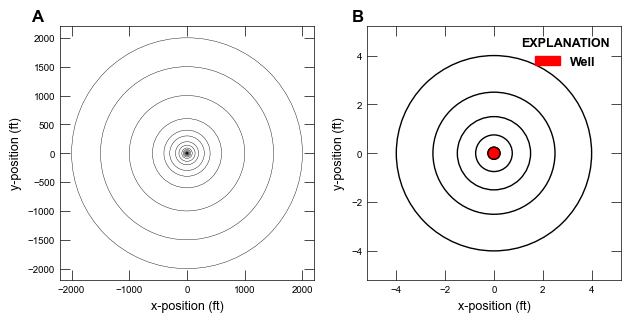

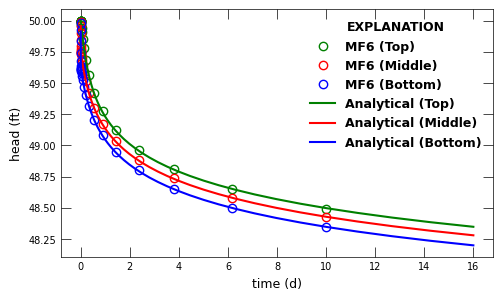

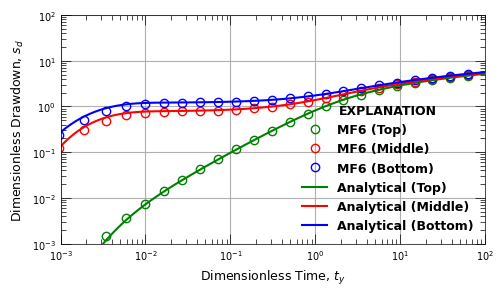

In [6]:
def scenario(silent=True):
    # key = list(parameters.keys())[idx]
    # params = parameters[key].copy()
    sim = build_models(sim_name)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)


# MF6 Axisymmetric Model
scenario()

if plot:
    # Solve analytical and plot results with MF6 results
    plot_results()